In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

## Titanic Competition

https://www.kaggle.com/c/titanic
    
## Data Dictionary
`Variable` `DefinitionKey`<br>
**survival**	Survival	0 = No, 1 = Yes
**pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
**sex**	Sex	
**Age**	Age in years	
**sibsp**	# of siblings / spouses aboard the Titanic	
**parch**	# of parents / children aboard the Titanic	
**ticket**	Ticket number	
**fare**	Passenger fare	
**cabin**	Cabin number	
**embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


**Variable Notes**<br>
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br>

sibsp: The dataset defines family relations in this way<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)<br>

parch: The dataset defines family relations in this way<br>
Parent = mother, father <br>
Child = daughter, son, stepdaughter, stepson <br>
Some children travelled only with a nanny, therefore parch=0 for them.<br>

In [21]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 
import opendatasets as od 
import os
from datetime import datetime 

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [33]:
train = pd.read_csv('./data/train.csv', index_col='PassengerId')
test = pd.read_csv('./data/test.csv', index_col='PassengerId')
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


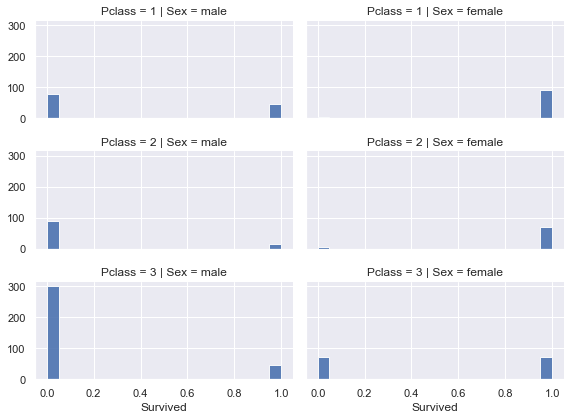

In [35]:
grid = sns.FacetGrid(train, col='Sex', row='Pclass', height=2, aspect=2)
grid.map(plt.hist, 'Survived', alpha=0.9, bins = 20)
grid.add_legend();

In [36]:
train[['Survived', 'Embarked']].groupby(by='Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


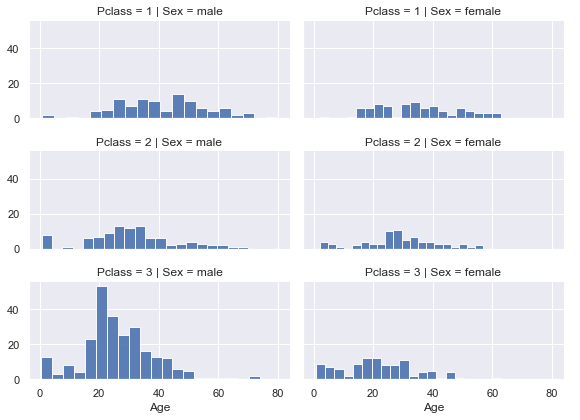

In [37]:
grid = sns.FacetGrid(train, col='Sex', row='Pclass', height=2, aspect=2)
grid.map(plt.hist, 'Age', alpha=0.9, bins = 20)
grid.add_legend();

As shown in this graph `Age` contains different distribution with the multiple classes of variables. 
So, we impute the `Age` using mean/median where we would groupby `Sex` and `Pclass`

In [38]:
ages = train[['Age', 'Pclass', 'Sex']].groupby(['Pclass', 'Sex']).median()
ages

Age
Pclass Sex         
1      female  35.0
       male    40.0
2      female  28.0
       male    30.0
3      female  21.5
       male    25.0

In [39]:
ages.loc[(2,'female')]

Age    28.0
Name: (2, female), dtype: float64

In [40]:
'''
for df in [train, test]:
    for row in df.itertuples():
        if np.isnan(row.Age):
            df.loc[row.Index, 'Age' ] = ages.loc[(row.Pclass, row.Sex)].Age
'''
#Following Custom transformer would provide the same result

"\nfor df in [train, test]:\n    for row in df.itertuples():\n        if np.isnan(row.Age):\n            df.loc[row.Index, 'Age' ] = ages.loc[(row.Pclass, row.Sex)].Age\n"

## Custom GroupImputer

In [41]:
class GroupImputer(BaseEstimator, TransformerMixin):
    '''Imputes a column based on the aggregation function supplied by the user,
    grouping data based on another set of columns in the DataFrame.
    
    col_to_impute : A string for a column name in the Dataframe.
    grouper : A list of column names to use to groupby and perform the imputation.
    agg_func : A numpy aggregation function (default is np.median)
    '''
    def __init__ (self, col_to_impute, grouper, agg_func= np.median):
        self.col_to_impute = col_to_impute 
        self.grouper = grouper
        self.agg_func = agg_func
    def fit(self, X, y= None):
        self.data = X[self.grouper + [self.col_to_impute]].groupby(self.grouper).agg({self.col_to_impute : self.agg_func})
    def transform(self, X):
        X_copy = X.copy()
        for row in X_copy.itertuples():
            if np.isnan(row._asdict()[self.col_to_impute]):
                tup = tuple([row._asdict()[k] for k in self.grouper])
                X_copy.loc[row.Index, self.col_to_impute] = self.data.loc[tup][self.col_to_impute]
        return X_copy

In [42]:
age_imputer = GroupImputer('Age', ['Pclass', 'Sex'])

In [43]:
age_imputer.fit(train)
age_imputer.fit(test)

In [44]:
train = age_imputer.transform(train)
test = age_imputer.transform(test)

In [45]:
print(train[train.Age.isna()])
print(test[test.Age.isna()])

Empty DataFrame
Columns: [Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []
Empty DataFrame
Columns: [Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


In [46]:
pd.crosstab( train['Survived'], train['Pclass'], margins=True)

Pclass,1,2,3,All
Survived,,,,
0,80,97,372,549
1,136,87,119,342
All,216,184,491,891


In [47]:
train[['Survived', 'Pclass']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [48]:
#78% for only predicting female survived all the time #Just based on one feature
y_gender_pred = (train['Sex'] == 'female').astype(int)
accuracy = sum(y_gender_pred == train['Survived'])/len(train['Survived'])
accuracy

0.7867564534231201

In [49]:
pd.crosstab(train['Survived'], train['Sex'], margins=True)

Sex,female,male,All
Survived,,,
0,81,468,549
1,233,109,342
All,314,577,891


In [50]:
# 74% Chance for females to survive
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [54]:
y_train = train.pop('Survived')
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

0    0.616162
1    0.383838
Name: Survived, dtype: float64


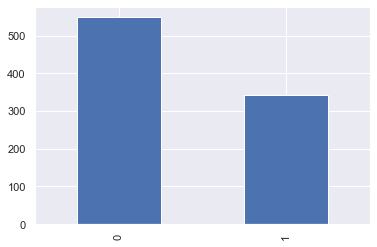

In [55]:
print(y_train.value_counts(normalize=True))
y_train.value_counts().plot(kind='bar');

In [57]:
test['Fare'] = test['Fare'].fillna(train['Fare'].median()) 

In [58]:
train.Embarked.isna().sum()

2

In [59]:
 train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [60]:
train.Embarked.mode()[0]

'S'

In [61]:
for df in [train, test]:
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [62]:
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

## Titles in Names 

In [63]:
train['Name'].values

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [64]:
for df in [train, test]:
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')

In [66]:
train.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Jonkheer      1
Countess      1
Mme           1
Ms            1
Capt          1
Lady          1
Don           1
Sir           1
Name: Title, dtype: int64

In [67]:
train = train.drop('Name', axis=1)
test = test.drop('Name', axis =1)